In [1]:
from radar import *
from rain import *

import matplotlib as mpl
import cartopy.crs as ccrs
import cartopy.io.shapereader as shpreader
import matplotlib.pyplot as plt
import cartopy.feature as cfeature
import pandas as pd 
import numpy as np

%matplotlib inline

In [2]:
TOP50 = pd.read_csv('../../Paper/TOP50_Events/TOP50_events_Charlotte.csv', parse_dates=[0,1])

In [184]:
c = Radar('charlotte', TOP50.t_begin[2], how='hdf5', store='TOP50.h5', fname='storm_{yyyy}_{mm:02d}_{dd:02d}', make_rate=4)

In [175]:
p[:,:,'area'].stack().describe()

count     43.000000
mean     108.139535
std      153.508272
min       20.000000
25%       30.500000
50%       55.000000
75%       99.000000
max      720.000000
dtype: float64

In [209]:
storm_speed = p[:,:,'Centroid Distance'].stack().mean()*4

In [210]:
storm_speed

0.37631594735165463

In [4]:
from rpy2 import robjects 
from rpy2.robjects.packages import importr
from rpy2.robjects import pandas2ri
pandas2ri.activate()
SpatialVx = importr('SpatialVx')
rsummary = robjects.r.summary

In [156]:
ll = np.array([c.lon.flatten('F'), c.lat.flatten('F')]).T

In [202]:
d={}
for i in range(48,96):
    hold = SpatialVx.make_SpatialVx(c.box[i,:,:], c.box[i+1,:,:], loc=ll)
    look = SpatialVx.FeatureFinder(hold, smoothpar=2, thresh=40, min_size=20)
    
    try:
        x = rsummary(look, silent=True)[0]
    except:
        continue
    p = pandas2ri.ri2py(x)
    df0 = pd.DataFrame(p, columns=['centroidX', 'centroidY', 'area', 'OrientationAngle', 
                                  'AspectRatio', 'Intensity0.25', 'Intensity0.9'])
    df0['Observed'] = list(df0.index+1)
    m = SpatialVx.centmatch(look, criteria=3, const=15)
    p = pandas2ri.ri2py(m[12])
    df1 = pd.DataFrame(p, columns=['Forecast', 'Observed'])
    l = SpatialVx.FeatureMatchAnalyzer(m)
    try:
        p = pandas2ri.ri2py(rsummary(l, silent=True))
    except:
        continue
    df2 = pd.DataFrame(p, columns=['Partial Hausdorff Distance','Mean Error Distance','Mean Square Error Distance',
                                  'Pratts Figure of Merit','Minimum Separation Distance', 'Centroid Distance',
                                  'Angle Difference','Area Ratio','Intersection Area','Bearing', 'Baddeleys Delta Metric',
                                  'Hausdorff Distance'])
    df3 = df1.join(df2)
    
    d.update({c.time[i]: pd.merge(df0, df3, how='outer')})
'''    
for k, v in d.items():
    v['lat']=np.nan
    v['lon']=np.nan
    for i in v.index:
        idX = int(np.round(v.centroidX[i]))
        idY = int(np.round(v.centroidY[i]))
        v.set_value(i, 'lat', c.lat[idX, idY])
        v.set_value(i, 'lon', c.lon[idX, idY])
'''
p = pd.Panel(d)

[1] "No matches found"
[1] "No matches found"


In [208]:
p[:,:,'Bearing'].stack().describe()

count     80.000000
mean      56.436753
std       83.564703
min     -167.808423
25%       35.051109
50%       88.907158
75%      107.807534
max      156.103860
dtype: float64

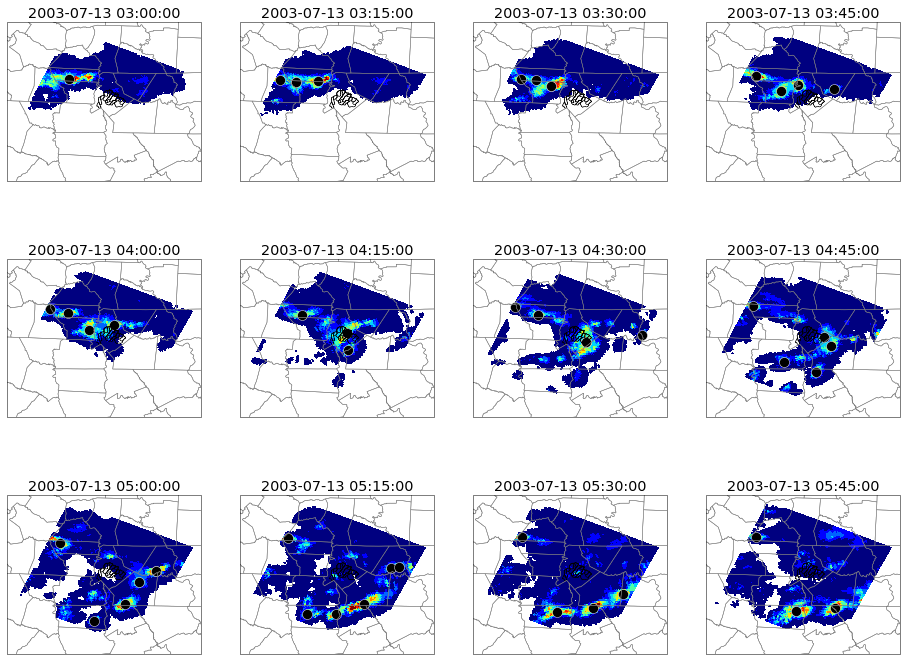

In [204]:
plt.figure(figsize=(16, 12))
n=1
for i in range(60,72):
    c.t = c.time[i]
    scat, ax = radar_map(c, feat=True, nrows=3, ncols=4, n=n)
    n+=1

In [176]:
%matplotlib inline
import matplotlib as mpl
import cartopy.crs as ccrs
import cartopy.io.shapereader as shpreader
import matplotlib.pyplot as plt
import cartopy.feature as cfeature
import pandas as pd 
import numpy as np

large_extent = [-82, -80, 34.5, 36]
small_extent = [-81.035000-.01, -80.552222+.01, 35.019722-.01, 35.507778+.01]

fname = '../../data/CHARLOTTE/Maps/new_basin.shp'
basins = list(shpreader.Reader(fname).geometries())

fname = '../../data/CHARLOTTE/Maps/county.shp'
county = list(shpreader.Reader(fname).geometries())

cmap = plt.cm.get_cmap('jet', 10)
cmap.set_under(color='None')


def radar_map(radar, feat=False, save=False, storm_mean=False, t_end=None, nrows=1, ncols=1, n=1, **kwargs):
    ax = plt.subplot(nrows, ncols, n, projection=ccrs.PlateCarree())

    ax.set_title(radar.t)
    i = radar.time.get_loc(radar.t)
    ax.add_geometries(basins, ccrs.PlateCarree(), edgecolor='black', facecolor='None')
    ax.add_geometries(county, ccrs.PlateCarree(), edgecolor='gray', facecolor='None')
    #ax.set_extent(small_extent, ccrs.PlateCarree())
    
    if storm_mean:
        scat = ax.pcolor(radar.lon, radar.lat, radar.box[i:radar.time.get_loc(t_end),:,:].mean(0),cmap=cmap)
        plt.colorbar(scat, fraction=0.05)
    else:
        scat = ax.pcolor(radar.lon, radar.lat, radar.box[i,:,:], vmin=.1, vmax=100, cmap=cmap)
    if feat:
        try:
            #ax.scatter(p[radar.t].lon, p[radar.t].lat, c='black',s=200)
            ax.scatter(p[radar.t].centroidX, p[radar.t].centroidY, c='black',s=100)
        except:
            print 'no features found'
            pass
    return(scat, ax)